In [12]:
from fermipy.gtanalysis import GTAnalysis
from gammapy.maps import Map, MapAxis
from gammapy.data import EventList
from astropy.coordinates import SkyCoord
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

# Data preparation

## Query

The data (photon event file and spacecraft file) were retrieved from the LAT data server, hosted on a public and continuously updated [website](https://fermi.gsfc.nasa.gov/cgi-bin/ssc/LAT/LATDataQuery.cgi), through a query defined by the following parameters:

| Galactic coordinates | Time range (MET) [s]  | Energy range  | Search radius|
|------|------|------|------|
|$(344.2^\mathrm{o}, -0.1^\mathrm{o})$   | $(239557417, 568889041)$ |  $(10\; \mathrm{GeV}, 1\; \mathrm{TeV})$| $2^\mathrm{o}$|

This dataset corresponds to $\sim 10$ years of Fermi LAT observaions (in Gregorian system, from the 4th of August 2008 to the 11th of January 2019).

The center of the ROI corresponds approximately with the position of the TeV extended source HESS J1702-420.   

We chose to adopt a 10 GeV energy threshold, in order to benefit of a relatively narrow PSF. The 68% containment radius of the LAT PSF is $0.15^\mathrm{o}$ at 10 GeV, and drops below $0.1^\mathrm{o}$ for $\gamma$-rays with energies beyond 35 GeV.

## Selection

The `GTAnalisis` class from fermipy, provides a friendly interface to the Fermi LAT Science Tools (hereafter, "stools"). In order to perform the analysis, the first step consists in creating an instance of `GTAnalisis` that reads from a config file, which specifies the data selection and binning that we want to adopt, together with the source catalog and diffuse emission templates that we wish to use for modeling the Region Of Interest (ROI). Namely, in this analysis we decide to adopt a spatial binning based on square pixels with side $0.05^\mathrm{o}$.

In [2]:
gta = GTAnalysis('config.yaml', logging={'verbosity' : 1}) # Set verbosity to 2 or 3 to get more output

Note that the slowest step of the data preparation (performed by `gta.setup()`) is the calculation of the livetime cube. The latter is, a 3D FITS file, storing the observation livetime as a function of sky position and off-axis angle. This step is useful in order to speed up the subsequent exposure map computation, but for a dataset as big as the one we are using it can take as long as 1 day (depending on the machine). That's why we provide the livetime cube already prepared, in the file ltcube_00.fits. In order to further speed up this step, we provide all its outputs and recommend the use of the "overwrite=False" argument in the next cell. The user who is interested in repeating this data preparation step may simply run `gta.setup(overwrite=True)` instead of the following cell, and substitute the key-value pair `ltcube : ltcube_00.fits` with `ltcube : null` in the config file.

In [3]:
gta.setup(overwrite=False)

## Dataset inspection

Before moving on with the analysis, we take a look at a few statistical properties of the dataset, plot an histogram representing the number of events in each energy bin, and plot a smoothed counts map for the ROI. 

In [4]:
events = EventList.read(
    "ft1_00.fits"
)
print(events)
events.energy.info("stats")

EventList info:
- Number of events: 4482
- Median energy: 1.66e+04 MeV

mean = 32145.8984375 MeV
std = 58339.9023438 MeV
min = 10001.6425781 MeV
max = 876268.0 MeV
n_bad = 0
length = 4482


In [9]:
print("Highest energy: {0:5.0f}".format(np.max(events.energy.to('GeV').value) * u.GeV))

Highest energy:   876 GeV


Events above   10 GeV:  4482
Events above   13 GeV:  3033
Events above   17 GeV:  2077
Events above   23 GeV:  1468
Events above   31 GeV:  1028
Events above   40 GeV:   711
Events above   54 GeV:   516
Events above   71 GeV:   346
Events above   94 GeV:   227
Events above  124 GeV:   150
Events above  164 GeV:   107
Events above  217 GeV:    67
Events above  287 GeV:    43
Events above  379 GeV:    27
Events above  502 GeV:    15
Events above  664 GeV:    11
Events above  878 GeV:     0


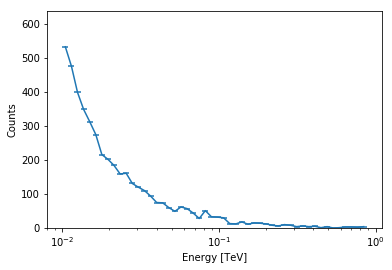

In [10]:
%matplotlib inline
events.plot_energy()

bins_edges=np.logspace(1, np.log10(877.938),17) * u.GeV # Edges of the evenly spaced (in log scale) energy bins
                                                        # used in the analysis, as defined in the config file
for e_min in bins_edges:
    n = (events.energy > e_min).sum()
    print("Events above {0:4.0f}: {1:5.0f}".format(e_min, n))

### As expected, most of the events are reconstructed in the energy range between 10 and few 10s of GeV. 
However, there are photons whose energies extend up and beyond 100s of GeV. Let's see now how the events are spatially distributed:

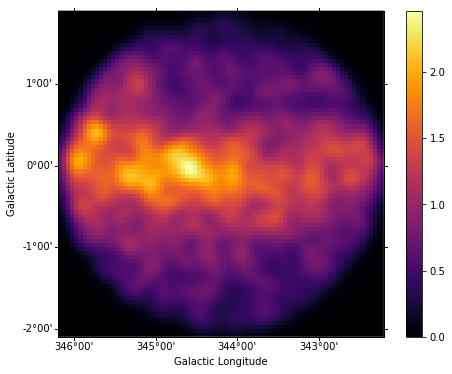

In [13]:
map_center = SkyCoord(344.2, -0.1, unit="deg", frame="galactic")
energy_axis = MapAxis.from_edges(
    bins_edges.value, name="energy", unit="GeV", interp="log"
)
counts_map = Map.create(
    skydir=map_center,
    npix=(80,80),
    proj="AIT",
    coordsys="GAL",
    binsz=0.05,
    axes=[energy_axis],
)

counts_map.fill_by_coord(
    {
        "skycoord": events.galactic,
        "energy": events.energy,
    }
)


# The counts map is smoothyed using a Gaussian kernel with
# 68% containment radius equal to 0.1 degrees. Indeed, above 
# 10 Gev the 68% containment radius of the Fermi LAT PFS drops
# around/below 0.1 degrees
# (http://www.slac.stanford.edu/exp/glast/groups/canda/lat_Performance.htm)
%matplotlib inline
plt.figure(figsize=(8, 6))

fig, ax, _ = counts_map.sum_over_axes().smooth(kernel="gauss", width=0.1 * u.deg).plot(add_cbar=True, cmap='inferno');

In [15]:
# Save the analysis checkpoint
counts_map.write("countsmap.fits", overwrite=True)
gta.write_roi('starting_model',make_plots=False,save_model_map=True)